In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, concat, read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Posterior Predictive Model Checking

### 1.1 Observed score distribution

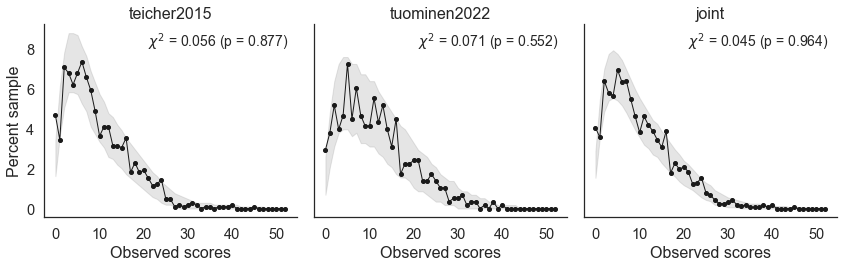

In [2]:
from arviz import hdi

## Initialize canvas.
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
studies = ['teicher2015','tuominen2022','joint']

for i, (ax, study) in enumerate(zip(axes, studies)):

    ## Load posterior predictive check.
    df = read_csv(os.path.join('stan_results', study, '2plq_m1_ppmc1.csv'), index_col=0)
    
    ## Normalize counts across samples.
    df.loc[:,:] /= df.loc[0].values.sum()
    
    ## Extract values.
    NC  = df.values[0]
    NCr = df.values[1:]
    ENC = NCr.mean(axis=0)
    
    ## Compute 95% HDI.
    lb, ub = np.apply_along_axis(hdi, 0, NCr, hdi_prob=0.95)
    
    ## Compute chi-square statistics.
    xi = np.sum(np.divide(np.square(NC - ENC), ENC, where=ENC > 0))
    xr = np.divide(np.square(NCr - ENC), ENC, where=ENC > 0).sum(axis=1)
    
    ## Compute ppp-value.
    pppv = (xi >= xr).mean()

    ## Plot observed scores and 95% HDI.
    ax.plot(np.arange(NC.size), NC, 'o-', color='k', lw=1, markersize=4)    
    ax.fill_between(np.arange(NC.size), lb, ub, color='0.5', alpha=0.2)
    
    ## Add detail.
    ax.set(xticks=np.arange(0,51,10), xlabel='Observed scores', yticks=np.arange(0,0.09,0.02), 
           yticklabels=np.arange(0,9,2), ylabel='', title=study)
    if not i: ax.set_ylabel('Percent sample')
    
    ## Add annotations.
    ax.annotate(r'$\chi^2$ = %0.3f (p = %0.3f)' %(xi, pppv), (0,0), (0.97, 0.97), 
                xycoords='axes fraction', ha='right', va='top', fontsize=14)
    
sns.despine()
plt.tight_layout()

### 1.2 Standardized generalized dimensionality discrepancy measure (SGDDM)

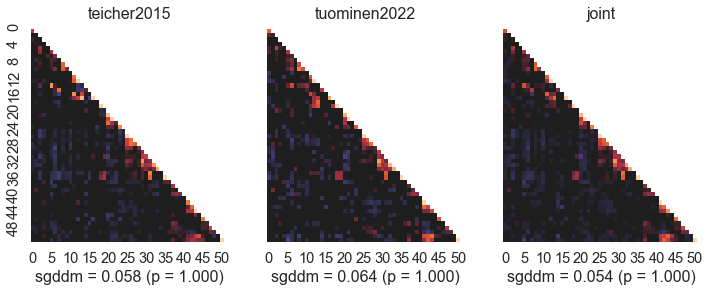

In [3]:
from arviz import hdi

## Initialize canvas.
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
studies = ['teicher2015','tuominen2022','joint']

for i, (ax, study) in enumerate(zip(axes, studies)):
    
    ## Load posterior predictive check.
    df = read_csv(os.path.join('stan_results', study, '2plq_m1_ppmc2.csv'))
    
    ## Extract posterior predictive check.
    sgddm, pppv = df.loc[0, ['mu', 'pval']]
    df = df.tail(-1)
    
    ## Construct square matrix.
    smbc = np.zeros((52,52)) * np.nan
    smbc[df.k1, df.k2] = np.where(np.logical_or(df.pval < 0.05, df.pval > 0.95), df.mu, 0)
    
    ## Plot square matrix.
    sns.heatmap(smbc, vmin=-0.5, vmax=0.5, center=0, mask=np.isnan(smbc), cbar=False, ax=ax)
        
    ## Add detail.
    ax.set(xlabel=r'sgddm = %0.3f (p = %0.3f)' %(sgddm, pppv), title=study)